In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from PIL import Image

In [2]:
# SUNRGBD/kv2/kinect2data/000547_2014-06-08_18-49-09_260595134347_rgbf000021-resize/image/0000021.jpg
intrinsic_path = "547intrinsics.txt"
extrinsic_path = "547extrinsics.txt"
depth_image_path = "547depth.png"
image_path = "547image.jpg"
mask_path = "547mask_best.txt"
all_class = ['objects', 'wall', 'objects', 'table', 'objects', 'sofa', 'wall', 'objects', 'chair', 'floor', 'wall', 'wall', 'picture']


### Load image and masks

530 730
(530, 730, 3)


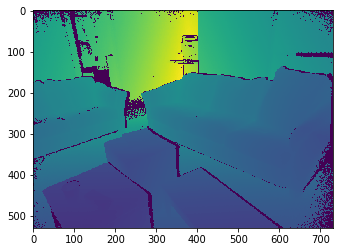

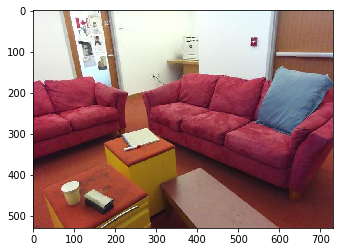

In [3]:
# Read Images 
dimg = np.array(Image.open(depth_image_path))
# dimg = mpimg.imread(depth_image_path) 
plt.figure()
plt.imshow(dimg) 
original_img = np.array(Image.open(image_path))
plt.figure()
plt.imshow(original_img) 

h,w = dimg.shape
print(h,w)
print(original_img.shape)


### Load masks

(13, 530, 730)


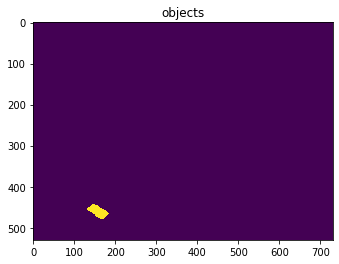

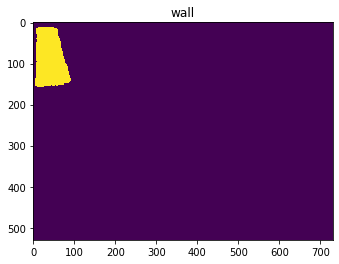

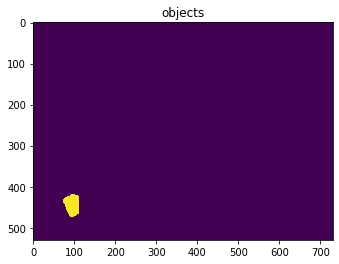

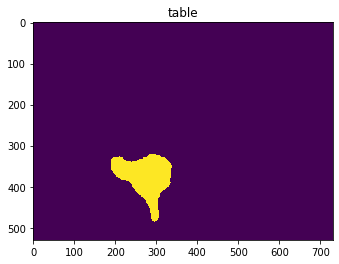

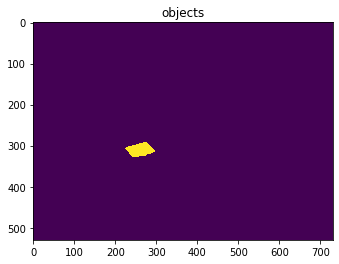

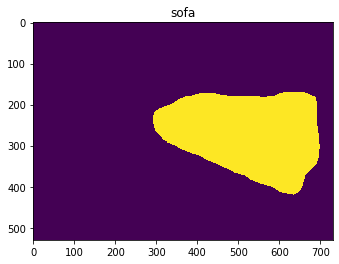

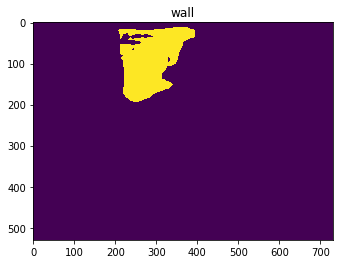

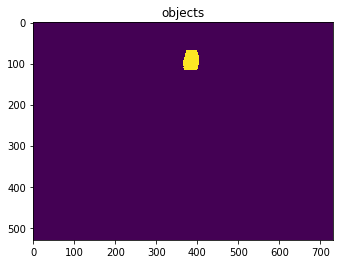

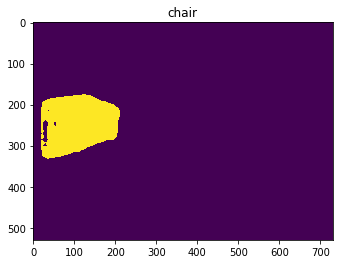

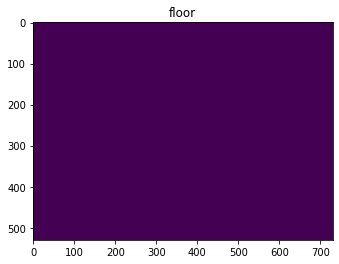

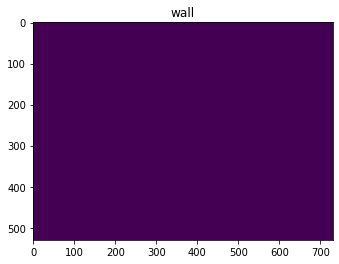

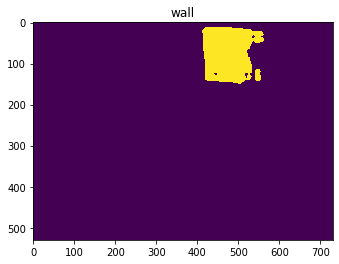

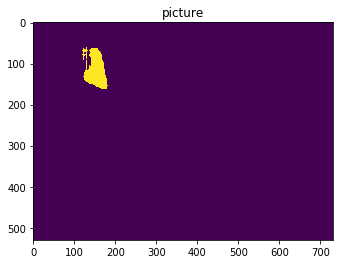

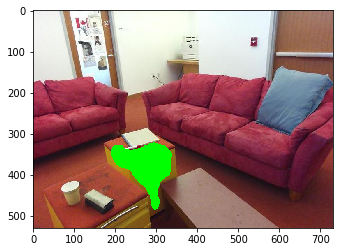

In [4]:
predict_mask = np.loadtxt(mask_path)
predict_mask = predict_mask.reshape((len(all_class), h, w))
print(predict_mask.shape)
# all_class = ['objects', 'wall', 'objects', 'table', 'objects', 'sofa', 'wall', 'objects', 'chair', 'floor', 'wall', 'wall', 'picture']
for i in range(len(all_class)):
    mask =  predict_mask[i,:,:]
    plt.figure()
    plt.imshow(mask)
    plt.title(all_class[i])
class_mask = predict_mask[3,:,:]
class_name = "Table"


original_img = np.array(Image.open(image_path))

imgray = np.array(class_mask, dtype = np.uint8) * 255
imgray = cv2.medianBlur(imgray, 7)
imgray = cv2.morphologyEx(imgray, cv2.MORPH_CLOSE, np.ones((10, 10), np.uint8))
ret, thresh = cv2.threshold(imgray, 100, 255,  cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.figure()
# print(contours)
img = cv2.drawContours(original_img, contours, 0, (0,255,0), -5)
plt.imshow(img)


### Load Intrinsic and Extrinsic matrix

In [5]:
intr = np.loadtxt(intrinsic_path)
extr = np.loadtxt(extrinsic_path)
# print(intrinsic_path)
print("Intrinsic Matrix")
print(intr)
# print(extrinsic_path)
print("Extrinsic Matrix")
print(extr)

Intrinsic Matrix
[[529.5   0.  365. ]
 [  0.  529.5 265. ]
 [  0.    0.    1. ]]
Extrinsic Matrix
[[ 0.997795 -0.065505 -0.010725  0.      ]
 [ 0.065505  0.945642  0.318545  0.      ]
 [-0.010725 -0.318545  0.947847  0.      ]]


#####  Focal length and coordinates of principle points

In [6]:
fu = intr[0,0]
fv = intr[1,1]
cu = intr[0,2]
cv = intr[1,2]
print(fu,fv,cu,cv)

529.5 529.5 365.0 265.0


### Recover real distance from depth images. Unit: meter.

In [7]:
distance = ((dimg>>3)|(dimg>>13))/1000
distance[distance > 8] = 8
print("max distance: {}".format(np.max(distance)))
print("min distance: {}".format(np.min(distance)))
# distance

max distance: 6.326
min distance: 0.0


##### process the distance and mask

In [8]:
sofa_distance_mask  = distance * class_mask
sofa_distance = sofa_distance_mask[np.where(sofa_distance_mask)] # eliminate error depth = 0
sofa_avg_distance = np.mean(sofa_distance)
sofa_max_distance = np.max(sofa_distance)
sofa_min_distance = np.min(sofa_distance)
print("avg:{}, max:{}, min:{}".format(sofa_avg_distance,sofa_max_distance,sofa_min_distance))
print(sofa_distance_mask.shape, sofa_distance.shape)


avg:1.563626028547439, max:1.697, min:1.411
(530, 730) (11910,)


### Coordinates Recovery
- Find farthest and nearest points
- 3D Bounding Box

In [9]:
far_vu = np.where(sofa_distance_mask == sofa_max_distance)
near_vu = np.where(sofa_distance_mask == sofa_min_distance)

# process far point
u = far_vu[1][0]
v = far_vu[0][0]
# print(u,v)
Z_optical = sofa_max_distance
X_optical = (u-cu)/fu * Z_optical
Y_optical = (v-cv)/fv * Z_optical
# print(X_optical,Y_optical,Z_optical)
fp_coor_opt = np.array([X_optical,Y_optical,Z_optical]).reshape(3,1) # far point coordinate
print("farthest point coordinate in optical frame: \n",fp_coor_opt)


# process near point
u = near_vu[1][0]
v = near_vu[0][0]
# print(u,v)
Z_optical = sofa_min_distance
X_optical = (u-cu)/fu * Z_optical
Y_optical = (v-cv)/fv * Z_optical
# print(X_optical,Y_optical,Z_optical)
np_coor_opt = np.array([X_optical,Y_optical,Z_optical]).reshape(3,1) # near point coordinate
print("nearest point coordinate in optical frame:\n ",np_coor_opt)

fp_coor_opt = np.vstack((fp_coor_opt, [1]))
# print(fp_coor_opt)
np_coor_opt = np.vstack((np_coor_opt, [1]))


farthest point coordinate in optical frame: 
 [[-0.22434372]
 [ 0.17947498]
 [ 1.697     ]]
nearest point coordinate in optical frame:
  [[-0.35974504]
 [ 0.29845515]
 [ 1.411     ]]


[190, 486, 339, 322]


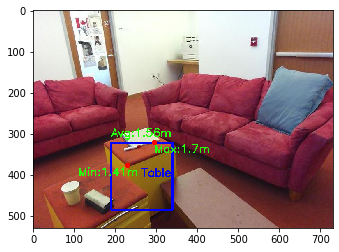

In [10]:
original_img = np.array(Image.open(image_path))
img = original_img

imgray = np.array(class_mask, dtype = np.uint8) * 255
imgray = cv2.medianBlur(imgray, 7)
imgray = cv2.morphologyEx(imgray, cv2.MORPH_CLOSE, np.ones((10, 10), np.uint8))
ret, thresh = cv2.threshold(imgray, 100, 255,  cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# plt.figure()
# # print(contours)
# img = cv2.drawContours(original_img, contours, 0, (0,255,0), -5)
# plt.imshow(img)


boxes = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    # Because Origin is left top
    bLeftX = x # x1
    bLeftY = y+h # y1
    tRightX = x+w # x2
    tRightY=y #y2
    print([bLeftX,bLeftY,tRightX,tRightY])
    boxes.append([bLeftX, bLeftY, tRightX, tRightY])

# cv2.rectangle(original_img, (x1, nr-y1), (x2, nr-y2), (0, 0, 255), 5)
img = cv2.rectangle(original_img, (bLeftX, bLeftY), (tRightX, tRightY), (0, 0, 255), 3)
cv2.putText(img, class_name, (x+int(w/2), y+int(h/2)),cv2.FONT_HERSHEY_SIMPLEX, 0.9,(0, 0, 255), 2)
text1 = "Avg:{}m".format(np.round(sofa_avg_distance,2))
# text2 = "Max:{}m, Min:{}m".format(np.round(sofa_max_distance,2),np.round(sofa_min_distance))
cv2.putText(img,"Avg:{}m".format(np.round(sofa_avg_distance,2)), (x,y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

cv2.putText(img, "Max:{}m".format(np.round(sofa_max_distance,2)), (far_vu[1],far_vu[0]+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
cv2.putText(img, "Min:{}m".format(np.round(sofa_min_distance,2)), (near_vu[1]-120,near_vu[0]+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
cv2.circle(img, (far_vu[1],far_vu[0]), 6, (255,0,0), -1)
cv2.circle(img, (near_vu[1],near_vu[0]), 6, (255,0,0), -1)
# cv.Circle(img, center, radius, color, thickness=1, lineType=8, shift=0) → None
plt.imshow(img)



In [11]:
print(far_vu)
print(near_vu)

(array([321], dtype=int64), array([295], dtype=int64))
(array([377], dtype=int64), array([230], dtype=int64))


In [12]:
T_extr = np.linalg.inv(np.concatenate((extr, np.array([0,0,0,1]).reshape(1,4)), axis = 0))
R2O = np.zeros((4,4))
R2O[0,1] = -1
R2O[1,2] = -1
R2O[2,0] = 1
R2O[3,3] = 1
# print(R2O)
T_extr = R2O.dot(T_extr)
print("pose extrinsic: \n",T_extr)

fp_coor_world = np.linalg.inv(T_extr).dot(fp_coor_opt)
fp_coor_world = fp_coor_world[0:3,:]
print("farthest point coordinate in world frame: \n",fp_coor_world)

np_coor_world = np.linalg.inv(T_extr).dot(np_coor_opt)
np_coor_world = np_coor_world[0:3,:]
print("nearest point coordinate in world frame:\n ",np_coor_world)

pose extrinsic: 
 [[ 0.06550507 -0.94564136  0.31854494  0.        ]
 [ 0.01072427 -0.31854494 -0.94784716  0.        ]
 [ 0.99779421  0.06550507 -0.01072427  0.        ]
 [ 0.          0.          0.          1.        ]]
farthest point coordinate in world frame: 
 [[ 1.68048735]
 [ 0.26613997]
 [-0.25977871]]
nearest point coordinate in world frame:
  [[ 1.38752458]
 [ 0.33754618]
 [-0.41261777]]


In [13]:
def uv2world(u,v, Z_opt, cu, cv, fu, fv, T_extr):
#     print(u,v, Z_opt)
    X_optical = (u-cu)/fu * Z_opt
    Y_optical = (v-cv)/fv * Z_opt
    # print(X_optical,Y_optical,Z_optical)
    coor_opt = np.array([X_optical,Y_optical,Z_opt]).reshape(3,1) # far point coordinate
#     print("point coordinate in optical frame: \n",coor_opt)

#     print("pose extrinsic: \n",T_extr)
    coor_opt = np.vstack((coor_opt, [1]))
    coor_world = np.linalg.inv(T_extr).dot(coor_opt)
    coor_world = coor_world[0:3,:]
#     print("point coordinate in world frame: \n",coor_world)
    return coor_world


# (bLeftX, bLeftY), (tRightX, tRightY)
nc_v, nc_u = near_vu
fc_v,fc_u = far_vu
near_corner = uv2world(nc_u,nc_v, sofa_distance_mask[nc_v,nc_u], cu,cv, fu,fv, T_extr)
far_corner  = uv2world(fc_u,fc_v, sofa_distance_mask[fc_v,fc_u], cu,cv,fu,fv,T_extr)


In [14]:
# cube side x,y,z
csx,csy,csz = far_corner - near_corner
csx = csx[0]
csy = csy[0]
csz = csz[0]
# print(csx,csy,csz)
pts_world = []
pt0 = near_corner
pts_world.append(pt0)
pt1 = pt0 + np.array([csx, 0 ,0]).reshape(3,1)
pts_world.append(pt1)
pt2 = pt0 + np.array([csx,csy,0]).reshape(3,1)
pts_world.append(pt2)
pt3 = pt0 + np.array([0, csy ,0]).reshape(3,1)
pts_world.append(pt3)
pt4 = pt0 + np.array([0, 0, csz]).reshape(3,1)
pts_world.append(pt4)
pt5 = pt0 + np.array([csx, 0, csz]).reshape(3,1)
pts_world.append(pt5)
pt6 = pt0 + np.array([csx, csy, csz]).reshape(3,1)
pts_world.append(pt6)
pt7 = pt0 + np.array([0, csy ,csz]).reshape(3,1)
pts_world.append(pt7)

imgpts = np.zeros((8,2))
for k,pt in enumerate(pts_world):
    pt = np.vstack((pt, [0]))
#     print(pt)
    opt_pt = T_extr.dot(pt)
#     print(opt_pt)
    opt_pt = opt_pt[0:3,:]
    opt_pt = opt_pt / opt_pt[2,0]
#     print(opt_pt)
    img_pt = intr.dot(opt_pt)
    img_pt = img_pt[0:2,:].reshape(1,2)[0]
#     print(img_pt)
    imgpts[k,:] = img_pt
    

    
imgpts = imgpts.astype(np.int32)


Function to draw 3D bounding box

In [15]:
def draw_cube(img,imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img

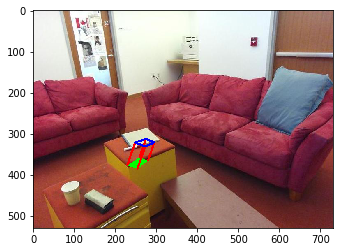

In [16]:
original_img = np.array(Image.open(image_path))
plt.figure()
plt.imshow(draw_cube(original_img, imgpts))

##### The result is strange because we use the nearest and farthest point as corners, which is not true due to imperfect mask.

##### We try to find the corners below:

In [17]:
minx = np_coor_world[0,0]
miny = np_coor_world[1,0]
minz = np_coor_world[2,0]
maxx = fp_coor_world[0,0]
maxy = fp_coor_world[1,0]
maxz = fp_coor_world[2,0]
num_pts = len(contours[0])
for i in range(num_pts):
    tmp_u = contours[0][i][0][0]
    tmp_v = contours[0][i][0][1]
    if (sofa_distance_mask[tmp_v,tmp_u] == 0):
        continue
    tmp_coor_world = uv2world(tmp_u,tmp_v, sofa_distance_mask[tmp_v,tmp_u], cu,cv,fu,fv, T_extr)
#     print(tmp_coor_world)
    tmpx = tmp_coor_world[0,0]
    tmpy = tmp_coor_world[1,0]
    tmpz = tmp_coor_world[2,0]
    minx = min(minx, tmpx)
    miny = min(miny, tmpy)
    minz = min(minz, tmpz)
    maxx = max(maxx, tmpx)
    maxy = max(maxy, tmpy)
    maxz = max(maxz, tmpz)
    
print(minx, miny, minz)
print(maxx, maxy, maxz)
    

1.3875245774362606 0.09029204126251172 -0.7508503667714828
1.6804873487110483 0.5471442527355995 -0.24825973674504256


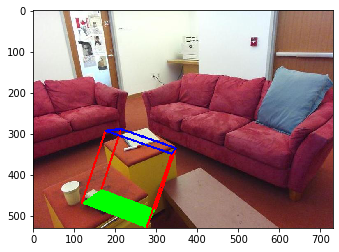

In [18]:
pts_world = []
pt0 = np.array([minx, miny ,minz]).reshape(3,1)
pts_world.append(pt0)
pt1 = np.array([maxx, miny ,minz]).reshape(3,1)
pts_world.append(pt1)
pt2 = np.array([maxx, maxy ,minz]).reshape(3,1)
pts_world.append(pt2)
pt3 = np.array([minx, maxy ,minz]).reshape(3,1)
pts_world.append(pt3)
pt4 = np.array([minx, miny ,maxz]).reshape(3,1)
pts_world.append(pt4)
pt5 = np.array([maxx, miny ,maxz]).reshape(3,1)
pts_world.append(pt5)
pt6 = np.array([maxx, maxy ,maxz]).reshape(3,1)
pts_world.append(pt6)
pt7 = np.array([minx, maxy ,maxz]).reshape(3,1)
pts_world.append(pt7)

imgpts = np.zeros((8,2))

# Project to 2D image
for k,pt in enumerate(pts_world):
    pt = np.vstack((pt, [0]))
#     print(pt)
    opt_pt = T_extr.dot(pt)
#     print(opt_pt)
    opt_pt = opt_pt[0:3,:]
    opt_pt = opt_pt / opt_pt[2,0]
#     print(opt_pt)
    img_pt = intr.dot(opt_pt)
    img_pt = img_pt[0:2,:].reshape(1,2)[0]
#     print(img_pt)
    imgpts[k,:] = img_pt
    

    
imgpts = imgpts.astype(np.int32)
# imgpts

original_img = np.array(Image.open(image_path))
plt.figure()
plt.imshow(draw_cube(original_img, imgpts))